In [1]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [2]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20190930-184558_9a1692cf7e18a770c19b61a0a2e05b04'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://ucla-deeplearning.s3-us-west-1.amazonaws.com/storage/mnist-v3/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_X.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_X.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_X.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_X.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_X.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_X.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_X.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [3]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

In [4]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt

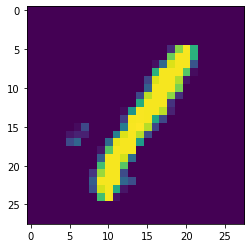

In [5]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[4]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels)

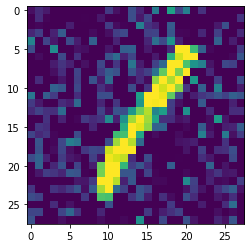

In [6]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[4]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels)

In [7]:
train_y.iloc[4]

digit    1
Name: 4, dtype: uint8

In [8]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

# IMPORTANT: This is an example of an undercomplete autoencoder.
# Your autoencoder has to be either sparse, denoising, or both.
# In other words, you will probably need to tweak these lines of code.
layers = [
    # Encoder: 50 nodes, Exponential Linear Unit activation
    Dense(units=50, activation='elu', input_shape=(28 * 28,)),
    
    # Decoder: matches the shape of the image
    # Sigmoid activation is needed because pixel
    # values are real numbers between 0 (black) and 1 (white).
    Dense(units=28*28, activation='sigmoid')
]

# Sequential class is a Keras class that attaches every 
# layer's output to the next layer's input.
# This is essentially a helper class for any feedforward networks.
autoencoder = Sequential(layers)

# Using MSE as the loss function, and Adam optimizer.
# Other optimizers and losses (e.g. binary cross entropy) can also be used.
autoencoder.compile(
    optimizer=optimizers.Adam(
        lr=0.01
    ), 
    loss='mean_squared_error'
)

In [9]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

# IMPORTANT: This is an example of an undercomplete autoencoder.
# Your autoencoder has to be either sparse, denoising, or both.
# In other words, you will probably need to tweak these lines of code.
history = autoencoder.fit(
    x=train_clean_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=3,
    
    batch_size=128,
    shuffle=True,
    validation_data=(validate_clean_X, validate_clean_X)
)

Epoch 1/3
383/383 [==============================] - 1s 2ms/step - loss: 0.0243 - val_loss: 0.0132
Epoch 2/3
383/383 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 3/3
383/383 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0109


In [10]:
# If you want to take a look at the learning curve,
# you can plot it using the following dictionary.
history.history

{'loss': [0.02427533082664013, 0.012531790882349014, 0.011364023201167583],
 'val_loss': [0.0131674287840724, 0.011952655389904976, 0.010911361314356327]}

In [11]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

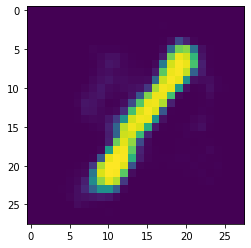

In [12]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[4]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels)
plt.show()

In [13]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.017829838269026035

In [15]:
import os 

model_dir = 'denoiser_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_dir}/score_denoised_X.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(autoencoder.to_json()), indent=True))

# Finally, let's save the learned parameters.
autoencoder.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset